# Introduction 

##Created by Blaž Škrlj, ICT2 programme

Text mining is one of the fastest growing fields of modern data science. Its applications range from sentiment analysis, fraud 
detection, semantic net analysis to discovery of new knowledge from existing data sources. There are many well known tools, raedily available for text analysis. Such tools include ontology editors, but also platforms for transforming the text into machine learning algorithm acceptable form. In this work, we consider one of such approaches using some of the well known libraries for text analysis in Python. 

Throughout the document, individual libraries are presented and thus are omitted in this introductory section. In this seminar work, the problem considered deals with prediction of writing style. Two styles are considered, namely objective and subjective style. The dataset considered is one of the well known datasets from this field, representing thousands of movie reviews of both types. The dataset can be found at the following address: http://www.cs.cornell.edu/people/pabo/movie-review-data/rotten_imdb.tar.gz

The procedure for construction of a predictive model, which can differ between different types of documents could be described in the following form:

* Preprocess the initial dataset into a format, which can be fed into a machine learning algorithm
* preprocessing techniques are to include some commons steps, such as:
    
    1. Stemming
    
    2. Stop word removal
    
    3. Removal of random characters
    
    4. Visualization
    
    5. Dictionary construction
    
    6. Vectorization
    
    7. Splitting
    
    8. Prediction
    
    9. Estimation
 
 
##first code block represents the file reading and reformatting to a suitable form

Before continuation of this analysis, let us state one of the main goals of this study.

The models constructed should be at least as good as the ones reported in scientific literature, where benchmark scores are from the article by Andrew L. et. al. (1), related to sentiment analysis. 

<img src="image.png">

Mind that we are using the third, "subjectivity" dataset.


# Modeling

In [1]:
# first, some imports, some are processing related, others are general

from nltk.corpus import stopwords
import collections
import pandas as pd
from nltk.stem.porter import *
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

## init stemmer
stemmer = PorterStemmer()

## stopwords selection
stop = set(stopwords.words('english'))

## init containers for further usage
train_corpus = []
test_corpus = []

## vocabulary for experimentation - this is very important!
vocab = [];

## Some additional tweaks
tabu_words = ["\n","(",")",'"']

## for dataset construction
index = 0

## preprocessing function
def stem_stopwords(entry):
    return list(filter(lambda x: x!= None,[stemmer.stem(word) if word not in 
                                           stop and word not in tabu_words 
                                           else None for word in entry.split(" ")]))

## read subjective dataset
with open('subjective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        if index <= 3500:
            ## this will be labeled as subj (0)
            train_corpus.append((int(1)," ".join(stem_stopwords(line))))
            
            for token in stem_stopwords(line):
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(1),(" ".join(stem_stopwords(line)))))

## read objective dataset
with open('objective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        ## from 5k to 8.5k are the next index ranges..
        if index <= 8500:
        ## labeled as (1)
            train_corpus.append((int(0)," ".join(stem_stopwords(line))))

            for token in stem_stopwords(line):
                
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(0),(" ".join(stem_stopwords(line)))))



In the first code section we can see, that each review is considered as a singled document. Whole dataframe could also be splitted in an arbitrary way. We can see, that we have prepared a vocabulary for matrix construction (vectorization), and two lists of processed reviews. As it will be seen later on, we decide to take 75% of the data as the train set and 25% as the test set. Cross validation procedure is implemented in a specialized pipeline for individual algorithms.

Before actually doing some vectorization, it can be useful to observe CDF (cumulative distribution function), to inspect the data visually, at least to some extent. Following images represent CDF for different dataset sizes

[('.', 8590), (',', 8250), ("'", 2453), ('film', 782), ('movi', 572), ('one', 530), ("n't", 489), ('it', 474), ('stori', 385), ('life', 363)]


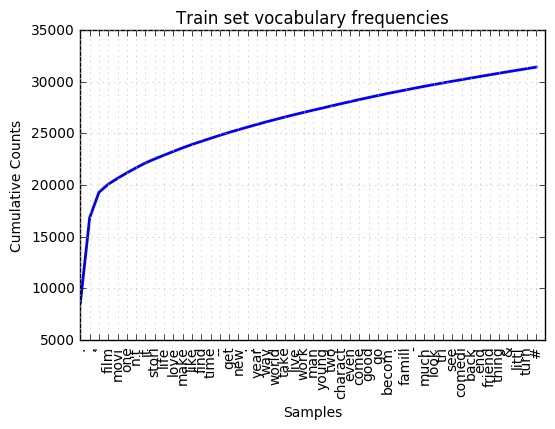

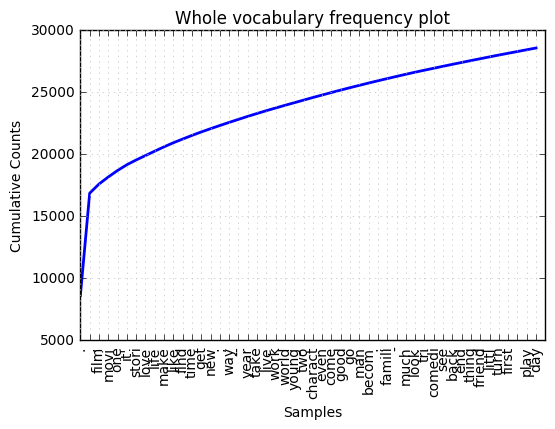

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


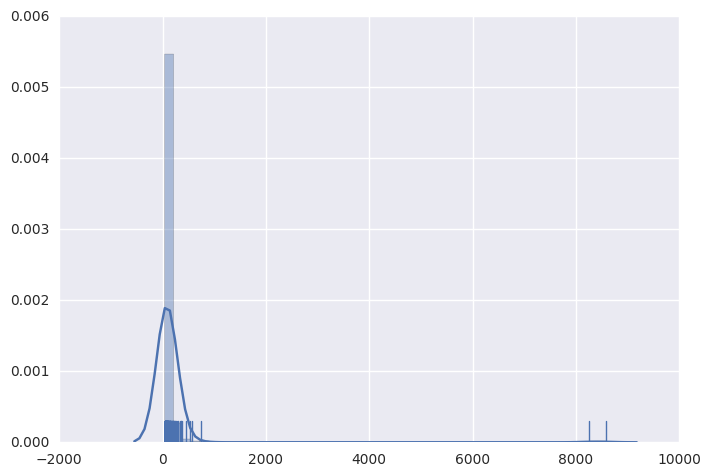

In [2]:
% matplotlib inline
from nltk import word_tokenize


# some common words
tokens = []
for entry in train_corpus:
    for token in word_tokenize(entry[1]):
        tokens.append(token)

fd1 = FreqDist(tokens)
fd2 = FreqDist(vocab)
print(fd1.most_common(10))


## plot frequencies
fd1.plot(50,cumulative=True, title="Train set vocabulary frequencies")
fd2.plot(50,cumulative=True, title="Whole vocabulary frequency plot")


most_common = [x for _,x in fd2.most_common(350)]

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(most_common, rug=True)

An important part of any machine learning process is the splitting of the data into two separate parts, a training and the test set. This can be done via a specialized function, like the one below:

In [ ]:
def get_train_test(corpus):
    corp = [x[1] for x in corpus]
    labs = [x[0] for x in corpus]
    vectorizer = TfidfVectorizer(min_df=1, max_features=50)
    X = vectorizer.fit_transform(corp)
    return X,labs

where the Tfidf function represents an important aspect of many text mining processes. Using Tfidf, defined as:

$$ TfIdf = Tf * Idf  $$ 

where Tf simply represents the term frequency 

$$ \frac{\sum_{n=1}^{occurs} n_{i}}  {\sum_{n=1}^{all} n_{i}} $$

and the Idf is represented as:

$$ Idf =  log \frac {N_{all_documents}}{N_{documents_contain_word}}   $$

From those equations we can see, that the the words taken into account in this vectorization process are contained in a vocabulary prior to the algorithm execution! Many implementations are capable of this step by themselves, yet if we wish to explore the effect of vocabulary (and later on features) on the models, we can construct it on our own.

Creation of the models is the key part, where we consider 3 different approaches (models). Support vector machines, Naive bayes and Deep learning. Although Naive bayes can also be used in a different ways to deal with textual data, we consider it here as a standard classifier. 

Another important aspect of this part of the processes is the data structure, responsible for containment of sparse matrices, that is, matrices with lots of zero valued elements (>97%). Such matrices are stored in special containers, where only non 0 elements are used along with pointers to their locations in the matrix. This is one of the standard approaches in numerical computation and linear algebra to reduce search space and make computation faster.

In [ ]:

svm_model = SVC(C=1000000.0, kernel='rbf')

pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('svm',svm_model)
])

parameters = {'svm__C' : [10,100,1000,10000],
              'tfidf__max_features' : list(range(1,10000,10))
}

## pipeline for SVMs
if __name__ == "__main__":

    grid_search = GridSearchCV(pipeline,parameters, n_jobs=4, verbose=1)
    t0 = time()
    grid_search.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


## pipeline for NB
pipeline2 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('MNB', MultinomialNB())
])

parameters2 = {'svm__C' : [10,100,1000,10000],
              'tfidf__max_features' : list(range(1,10000,10))
}

if __name__ == "__main__":

    grid_search2 = GridSearchCV(pipeline2,parameters2, n_jobs=4, verbose=1)
    t0 = time()
    grid_search2.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search2.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search2.best_estimator_.get_params()
    for param_name in sorted(parameters2.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

# done in 27933.576s
# Best score: 0.884
# Best parameters set:
# 	svm__C: 1000
# 	tfidf__max_features: 5881


The code abowe demonstrates the grid search option for exploration of different models. The same principle can be applied to train the Naive bayesian classifier, which is formally defined as:

$$ p(C_{k}|x_{1}..x_{n}) =argmax (p(C_{k}) \prod_{i=1}^{n} p(x_{i}|C_{k})) $$

Although one of the simplest possible models, this concept many times appears as the best option for text mining related problems. In the section below, we present the implementation of multinomialNB method using sklearn library (Python3).

In [ ]:
## pipeline for NB
pipeline2 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('MNB', MultinomialNB())
])

parameters2 = {
              'tfidf__max_features' : list(range(1,10000,10))
}

if __name__ == "__main__":

    grid_search2 = GridSearchCV(pipeline2,parameters2, n_jobs=4, verbose=1)
    t0 = time()
    grid_search2.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search2.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search2.best_estimator_.get_params()
    for param_name in sorted(parameters2.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))



# Best score: 0.901
# Best parameters set:
# 	tfidf__max_features: 9741


The same process can be conducted with one small difference - use of lemmatizer instead of a simple Porter stemmer. The code below demonstrates this task.

In [ ]:
## this will test the lematization approach.

from nltk.stem import WordNetLemmatizer
import numpy as np
from nltk.corpus import stopwords
import collections
import pandas as pd
from nltk.stem.porter import *
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time
from sklearn.naive_bayes import MultinomialNB


## Read the subjective files..
subjective = {}
stemmer = PorterStemmer() ## construct a stemmer
stop = set(stopwords.words('english'))

train_corpus = []
test_corpus = []

vocab = [];
tabu_words = ["\n","(",")",'"']

## for dataset construction
index = 0
wordnet_lemmatizer = WordNetLemmatizer()


## preprocessing function - use lematization
def stem_stopwords(entry):
    return list(filter(lambda x: x!= None,[wordnet_lemmatizer.lemmatize(word) 
                                           if word not in stop and word 
                                           not in tabu_words 
                                           else None for word in entry.split(" ")]))

with open('subjective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        if index <= 3500:
            ## this will be labeled as subj (0)
            train_corpus.append((int(1)," ".join(stem_stopwords(line))))
            for token in stem_stopwords(line):
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(1),(" ".join(stem_stopwords(line)))))


with open('objective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        ## from 5k to 8.5k are the next index ranges..
        if index <= 8500:
        ## labeled as (1)
            train_corpus.append((int(0)," ".join(stem_stopwords(line))))

            for token in stem_stopwords(line):
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(0),(" ".join(stem_stopwords(line)))))



#.fit(train_data, train_labs)

# predictions_svm = svm_model.predict(train_data)
# print("SVM accuracy in %: ",accuracy_score(train_labs,predictions_svm))




pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('svm',SVC(C=1000000.0, kernel='rbf'))
])

parameters = {'svm__C' : [10,100,1000,10000],
              'tfidf__max_features' : [1000,2000,3000,4000]
}

## pipeline for SVMs
if __name__ == "__main__":

    grid_search = GridSearchCV(pipeline,parameters, n_jobs=4, verbose=1)
    t0 = time()
    grid_search.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    predictions = grid_search.best_estimator_.predict([x[1] for x in test_corpus]) # test labs
    targets = [x[0] for x in test_corpus]
    print ("SVM: ",accuracy_score(predictions,targets))


## pipeline for NB
pipeline2 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('MNB', MultinomialNB())
])

parameters2 = {
              'tfidf__max_features' : [3000,4000]
}

if __name__ == "__main__":

    grid_search2 = GridSearchCV(pipeline2,parameters2, n_jobs=4, verbose=1)
    t0 = time()
    grid_search2.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search2.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search2.best_estimator_.get_params()
    for param_name in sorted(parameters2.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    predictions = grid_search2.best_estimator_.predict([x[1] for x in test_corpus]) # test labs
    targets = [x[0] for x in test_corpus]
    print ("NB: ",accuracy_score(predictions,targets))   #0.89

    ## output
    python3 lematizetest.py 
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:  1.1min finished
done in 74.157s
Best score: 0.872
Best parameters set:
	svm__C: 1000
	tfidf__max_features: 4000
SVM:  0.884666666667
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.6s finished
done in 1.143s
Best score: 0.892
Best parameters set:
	tfidf__max_features: 4000
NB:  0.897

real	1m23.177s
user	4m40.508s
sys	0m2.348s


Up to now, we demonstrated, that repeated cross validation procedure can be a feasible training method for construction of objectivity classifiers. The methods implemented achieve accuracy near current state-of-the-art methods, which dwelve a bit deeper into enrichment of the dataset for example. Up to now we have thus tried:

* SVM
* Naive Bayes

Of which NB performed a bit better. Next possible step would include a more sophisticated prediction method, such as deep learning or additional preprocessing of the dataset in order to obtain better results. We decide to continue from the TFIDF obtained and construct a deep learning algorithm, capable of learning the difference between the objective and subjective documents. The following algorithm is implemented using the Theano library, an efficient, GPU based library for dealing with tensors. We use Nvidia GeForce 560 series GPU to train the model, which already represents the first difference between other models and the DL one - the computational time required.

For successful implementation of the deep learning algorithm, we also use Keras, a higher level abstraction to construct deep learning algorithms. This implementation can not deal with sparse matrices, as the train matrix is meant to be trained in batches. This can be achieved using the following process

In [ ]:
from keras.preprocessing.text import Tokenizer, one_hot
import numpy as np


def test_one_hot():
    text = 'The cat sat on the mat.'
    encoded = one_hot(text, 5)
    print (encoded)


def test_tokenizer():
    texts = ['The cat sat on the mat.',
             'The dog sat on the log.',
             'Dogs and cats living together.']
    tokenizer = Tokenizer(nb_words=5)
    tokenizer.fit_on_texts(texts)

    sequences = []
    for seq in tokenizer.texts_to_sequences_generator(texts):
        sequences.append(seq)
    print (sequences)

    tokenizer.fit_on_sequences(sequences)

    for mode in ['binary', 'count', 'tfidf', 'freq']:
        matrix = tokenizer.texts_to_matrix(texts, mode)
        print (matrix)

test_tokenizer()


# >>> from nltk.stem import WordNetLemmatizer
# >>> wordnet_lemmatizer = WordNetLemmatizer()
# >>> wordnet_lemmatizer.lemmatize(‘dogs’)
# u’dog’
# >>> wordnet_lemmatizer.lemmatize(‘churches’)
# u’church’
# >>> wordnet_lemmatizer.lemmatize(‘aardwolves’)

Deep learning algorithm is presented in the following code snippet:

In [ ]:
from keras.preprocessing.text import Tokenizer, one_hot

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, activity_l2
import numpy as np
from keras.layers import Dropout
from nltk.corpus import stopwords
import collections
import pandas as pd
from nltk.stem.porter import *
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time
from sklearn.naive_bayes import MultinomialNB

## Read the subjective files..
subjective = {}
stemmer = PorterStemmer() ## construct a stemmer
stop = set(stopwords.words('english'))

train_corpus = []
test_corpus = []

vocab = [];
tabu_words = ["\n","(",")",'"']

## for dataset construction
index = 0

## preprocessing function
def stem_stopwords(entry):
    return list(filter(lambda x: 
                       x!= None,[stemmer.stem(word) if 
                                           word not in stop and word not in 
                                           tabu_words else None for word in entry.split(" ")]))

with open('subjective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        if index <= 3500:
            ## this will be labeled as subj (0)
            train_corpus.append((int(1)," ".join(stem_stopwords(line))))
            for token in stem_stopwords(line):
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(1),(" ".join(stem_stopwords(line)))))


with open('objective.txt','r',encoding="ISO-8859-1") as f:
    for line in f:
        index +=1
        ## from 5k to 8.5k are the next index ranges..
        if index <= 8500:
        ## labeled as (1)
            train_corpus.append((int(0)," ".join(stem_stopwords(line))))

            for token in stem_stopwords(line):
                ## common vocabulary
                vocab.append(token)
        else:
            test_corpus.append((int(0),(" ".join(stem_stopwords(line)))))




### up to this point, we do not change the code!

## Train data is still in the format: [(label, text)...].

## We need to transform the train and also the test corpus

## specify frequencies, this constructs different number of features..
def trim_vocab(corpus, freq):
    return set(filter(lambda x: x != None, [s if corpus.count(s) > freq else None for s in vocab]))

#print (len(trim_vocab(vocab,60)))

train_labs, train_text = [x for x,_ in train_corpus], [x for _,x in train_corpus]
test_labs, test_text = [x for x,_ in test_corpus], [x for _,x in test_corpus]

tfidf_transformer = TfidfVectorizer(vocabulary= trim_vocab(vocab,30))
X_train_tfidf = tfidf_transformer.fit_transform(train_text)
X_test_tfidf =  tfidf_transformer.fit_transform(test_text)

print(X_train_tfidf.shape)

input_size = X_train_tfidf.shape[1]

x_train = X_train_tfidf.toarray()
x_test = X_test_tfidf.toarray()

initsize = input_size
model = Sequential()
model.add(Dense(int(initsize), input_dim=input_size, init='uniform', activation='relu'))
model.add(Dense(300, init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(150, init='uniform', activation='relu'))
model.add(Dense(80, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, init='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
model.fit(x_train, train_labs, nb_epoch=15, batch_size=10, verbose=0)
 
score = model.evaluate(x_test, test_labs, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


____________________
Layer (type)                     Output Shape          Param #     Connected to                     
====================================================================================================
dense_1 (Dense)                  (None, 2658)          7067622     dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 600)           1595400     dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 600)           0           dense_2[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 150)           90150       dropout_1[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 80)            12080       dense_3[0][0]                    
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 80)            0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 30)            2430        dropout_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 30)            0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 20)            620         dropout_3[0][0]                  
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 5)             105         dense_6[0][0]                    
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 5)             0           dense_7[0][0]                    
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 1)             6           dropout_4[0][0]                  
====================================================================================================
Total params: 8,768,413
Trainable params: 8,768,413
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/15



We can also try with a simple, convolutional neural network!

In [ ]:
from sklearn.neural_network import MLPClassifier
pipeline3 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('nn',MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1))
])

parameters2 = {
    'tfidf__max_features' : [3000,4000,6000,8000,10000],
    'nn__hidden_layer_sizes' : [(5,2),(10,2),(15,2),(15,5),(15,10),(80,20,5)]
}

if __name__ == "__main__":

    grid_search2 = GridSearchCV(pipeline3,parameters2, n_jobs=4, verbose=1)
    t0 = time()
    grid_search2.fit([x[1] for x in train_corpus], [x[0] for x in train_corpus])
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search2.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search2.best_estimator_.get_params()
    for param_name in sorted(parameters2.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    predictions = grid_search2.best_estimator_.predict([x[1] for x in test_corpus]) # test labs
    targets = [x[0] for x in test_corpus]
    print ("nn: ",accuracy_score(predictions,targets))   
    
    
    # results
    Fitting 3 folds for each of 30 candidates, totalling 90 fits
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.2s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  4.9min finished
done in 300.584s
Best score: 0.873
Best parameters set:
	nn__hidden_layer_sizes: (15, 5)
	tfidf__max_features: 8000
nn:  0.868666666667


Algorithms used in this study represent different learning paradigms, and we can observe the following>

First: neural network based methods overall perform a bit worse than the SVM and NB classifiers.
    
Approaches can not be optimized using lematization, stemming is a better alternative.

In [5]:
import pandas as pd
import numpy as np

d = {'Naive Bayes' : [0.90, 0.86,"4min/model"],
     'SVM' : [0.884, 0.85,"2-3min/model"],
    'Neural net' : [0.873, "/","20min/model"],
    'Deep architecture' : [0.862, "/","Days/model (GPU)"]} 

pd.DataFrame(d,index=["Stemming","Lematization","Train time"])

## all algorithms were extensively tested on different tfidf feature space sizes, 
## maximal performance was achieved using NB with more than 9000 features


,Deep architecture,Naive Bayes,Neural net,SVM
Stemming,0.862,0.9,0.873,0.884
Lematization,/,0.86,/,0.85
Train time,Days/model (GPU),4min/model,20min/model,2-3min/model


# interpretation of the results

One of the main observations is, that the NB model performed extremely well compared to other models. An interesting observation is also, that the deep learning architecture constructed obtained similar results with about a 25% of features used for other algorithms (800-1000). Each algorithm could be aditionally tuned for beter performance, yet main aim of this study is to observe, whether an ad hoc deep learning architecture can be constructed, which can in fact perform similarly to known methods. This goal was partially achieved, yet due to high computational complexity, such architecture is infeasible to train on an average consumer GPU card.

## Comparison to the benchmark study

As one of the main goals was to prove, that algorithms with same accuracy can be constructed for the study by Maas et. al. Main observation regarding these results is, that Naive Bayes again performed better than other methods, and similarly to the best accuracy scores in the aforementioned paper. Constructed deep learning architecture performed on the worse end, compared to other classifiers, yet as it was mentioned before, this is an optimal opportunitiy for further improvements, which might capture the latent features, currently not well described.


# Bibliography

Bird, S., 2006. NLTK: the natural language toolkit. Association for Computational Linguistics, pp. 69–72. doi:10.3115/1225403.1225421

Maas, A.L., 2011. Learning Word Vectors for Sentiment Analysis. HLT ’11 Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies - Volume 1 142–150.

Pang, B., Lee, L., 2004. A sentimental education: sentiment analysis using subjectivity summarization based on minimum cuts. Association for Computational Linguistics, p. 271–es. doi:10.3115/1218955.1218990

Pang, B., Lee, L., Vaithyanathan, S., 2002. Thumbs up?: sentiment classification using machine learning techniques. Association for Computational Linguistics, pp. 79–86. doi:10.3115/1118693.1118704
